In [1]:
import os
import numpy as np
from scipy import ndimage
import SimpleITK as sitk
import matplotlib.pyplot as plt
get_ipython().magic('pylab inline')

import FunctionsCustom as fun

Populating the interactive namespace from numpy and matplotlib


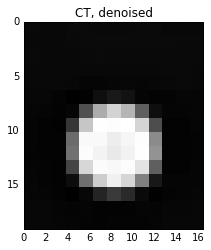

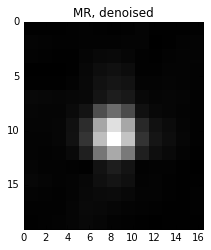

In [2]:
# path to the cropped, aligned CT and MR images

pathCT = "../data/cropped_CT-a/"
pathMR = "../data/cropped_MR-d-a/"

imgOriginalCT = fun.sitk_read(pathCT)
imgOriginalMR = fun.sitk_read(pathMR)

idxSlice = 10
labelRod = 1

# denoise:

imgSmoothCT = sitk.CurvatureFlow(image1=imgOriginalCT,
                                    timeStep=0.125,
                                    numberOfIterations=5)

imgSmoothMR = sitk.CurvatureFlow(image1=imgOriginalMR,
                                    timeStep=0.125,
                                    numberOfIterations=5)
                                    
fun.sitk_show(imgSmoothCT[:,:,idxSlice], title="CT, denoised")
fun.sitk_show(imgSmoothMR[:,:,idxSlice], title="MR, denoised")

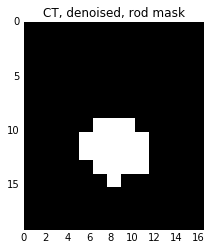

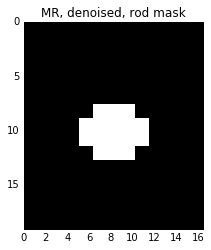

In [3]:
# set seed for segmentation
seedFillingCT = [(8,8,idxSlice)]
seedFillingMR = [(8,8,idxSlice)]

# using ConnectedThresholdImageFilter we can create a mask of just the rod
# https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ConnectedThresholdImageFilter.html
maskRodCT = sitk.ConnectedThreshold(image1=imgSmoothCT, 
                                              seedList=seedFillingCT, 
                                              lower=00, 
                                              upper=300,
                                              replaceValue=labelRod)

maskRodMR = sitk.ConnectedThreshold(image1=imgSmoothMR, 
                                              seedList=seedFillingMR, 
                                              lower=80, 
                                              upper=1500,
                                              replaceValue=labelRod)

fun.sitk_show(maskRodCT[:,:,idxSlice], title="CT, denoised, rod mask")
fun.sitk_show(maskRodMR[:,:,idxSlice], title="MR, denoised, rod mask")

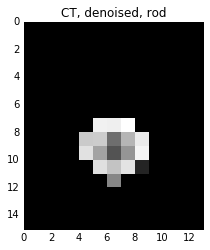

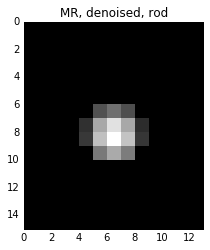

In [4]:
# now we use a custom function (see "FunctionCustom") to get rid of everything but the rod in the denoised image
# since it is denoised already, this will not make a huge difference

imgRodCT = fun.sitk_mask(imgSmoothCT, maskRodCT)
imgRodMR = fun.sitk_mask(imgSmoothMR, maskRodMR)

fun.sitk_show(imgRodCT[:,:,idxSlice], title="CT, denoised, rod")
fun.sitk_show(imgRodMR[:,:,idxSlice], title="MR, denoised, rod")

In [5]:
# Using this command we can look at imgRodMR with 3D Slicer:
# %env SITK_SHOW_COMMAND /home/david/Downloads/Slicer-4.5.0-1-linux-amd64/Slicer
# sitk.Show(imgRodMR)

In [6]:
# important to remember:
# sitk.Image saves Volume like this (x,y,z)
# array returned by sitk.GetArrayFromImage(Image) is transposed: (z,y,x)

# we now use numpy to calculate the centroid of the rod
rodCT = sitk.GetArrayFromImage(imgRodCT)
zCT, yCT, xCT = np.shape(rodCT)

rodMR = sitk.GetArrayFromImage(imgRodMR)
zMR, yMR, xMR = np.shape(rodMR)

# create array with centroid of rod in each slice of CT and MRT
centroidCT = np.zeros((zCT, 2))
centroidMR = np.zeros((zMR, 2))

for slice in range(zCT):
    centroidCT[slice,:] = np.array(ndimage.measurements.center_of_mass(rodCT[slice,:,:]))

for slice in range(zMR):
    centroidMR[slice,:] = np.array(ndimage.measurements.center_of_mass(rodMR[slice,:,:]))

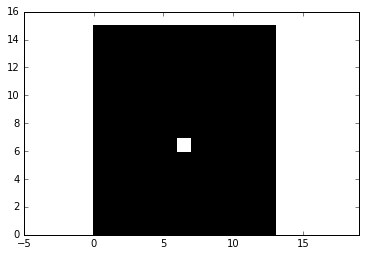

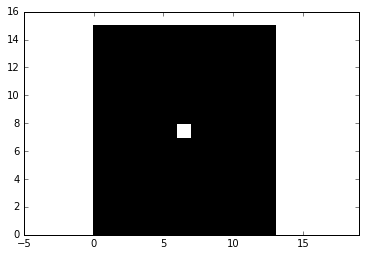

In [7]:
# to make the result visible in our image, we can set the pixel closest to the centroid to 1
# everything else will be black (value of 0)
centroidCT_int = centroidCT.astype(int)

imgCentroidCT = np.zeros((zCT, yCT, xCT))
for slice in range(zCT):
    imgCentroidCT[slice, centroidCT_int[slice,0], centroidCT_int[slice,1]] = 1
    
fun.array_show(imgCentroidCT[0,:,:])


centroidMR_int = centroidMR.astype(int)

imgCentroidMR = np.zeros((zMR, yMR, xMR))
for slice in range(zMR):
    imgCentroidMR[slice, centroidMR_int[slice,0], centroidMR_int[slice,1]] = 1
    
fun.array_show(imgCentroidMR[0,:,:])

In [8]:
# this looks pretty good already
# lets calculate the centroid shift in every slice:

if zCT == zMR:
    centroidDiff = np.zeros((zCT, 2))
    for slice in range(zCT):
        centroidDiff[slice,0] = centroidCT[slice,0] - centroidMR[slice, 0]
        centroidDiff[slice,1] = centroidCT[slice,1] - centroidMR[slice, 1]
        
print(centroidDiff)

[[ 1.01718766  0.09381155]
 [ 1.01126068  0.08987856]
 [ 1.00248029  0.08475168]
 [ 0.99652355  0.08011549]
 [ 0.98718933  0.07433351]
 [ 0.98313596  0.06798372]
 [ 0.97608611  0.06274943]
 [ 0.97180472  0.05785591]
 [ 0.96247344  0.05599176]
 [ 0.95308068  0.05265702]
 [ 0.93883027  0.04992943]
 [ 0.92482991  0.04632092]
 [ 0.90614414  0.04450326]
 [ 0.88419383  0.04178457]
 [ 0.86581921  0.03977833]
 [ 0.774719   -0.00449801]
 [ 0.72366367  0.06903388]
 [ 0.71095843  0.06528336]
 [ 0.70140084  0.06254602]
 [ 0.68689293  0.05939225]
 [ 0.67294896  0.05888521]
 [ 0.61360485  0.07689806]
 [ 0.56043085  0.05972924]
 [ 0.55002884  0.06325302]
 [ 0.53693745  0.06664099]
 [ 0.52312274  0.07081612]
 [ 0.50999322  0.0728887 ]
 [ 0.50114113  0.07553456]
 [ 0.49269616  0.07684377]
 [ 0.50448941  0.1178926 ]
 [ 0.49340079  0.11706776]
 [ 0.48658615  0.11770266]
 [ 0.47599124  0.118033  ]
 [ 0.45576643  0.07894771]
 [ 0.4505808   0.07737321]
 [ 0.44427054  0.07231985]
 [ 0.43704     0.06531532]
 